### Make sure GPU is on

https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import tensorflow_datasets as tfds
import random 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Flatten
from skimage.util import montage

Using TensorFlow backend.


### (10 pts.) Prepare the datasets

#### load the plant_village data from tensorflow_datasets. Split by %80-10-10 train-val-test using split= input.

#### Please check https://www.tensorflow.org/datasets/splits

In [3]:
raw_test = tfds.load('plant_village', split='train[:10%]', as_supervised=True)  #### fill here
raw_val = tfds.load('plant_village', split='train[10:20%]', as_supervised=True) #### fill here
raw_train = tfds.load('plant_village', split='train[20:100%]', as_supervised=True) #### fill here

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.0.incompleteQJT1QE/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.0. Subsequent calls will reuse this data.


#### Normalize each image into [0,1] range, shuffle and minibatch 128.

In [0]:
pp_test = raw_test.map(lambda img, label: (tf.image.convert_image_dtype(img/255, tf.float32), label) ).shuffle(1024).batch(128)
pp_val = raw_val.map(lambda img, label: (tf.image.convert_image_dtype(img/255, tf.float32), label) ).batch(128)
pp_train = raw_train.map(lambda img, label:(tf.image.convert_image_dtype(img/255, tf.float32), label) ).batch(128)

#### Display the examples from the dataset.

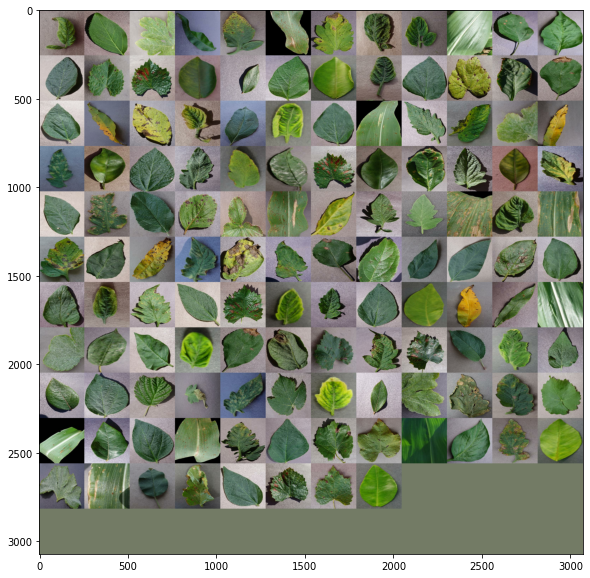

In [5]:
plt.figure(figsize=(10,10))
for example in pp_train.take(1):  # Only take a single example
  image, label = example[0], example[1]
  plt.imshow(montage(image, multichannel=True))

### (20 pts) The Fully Connected Neural Network implementation

#### It is a 4 layer (Fully Connected) Neural Network. The feature depths are [512,256,128] and last softmax layer has 38 output. Train for 10 epochs, with 0.001 learning rate and categorical cross entropy.

In [6]:
model = tf.keras.models.Sequential([
                                
  ### Flatten
  tf.keras.layers.Flatten(input_shape=(256,256,3)),
  ### Dense
  tf.keras.layers.Dense(512, activation='relu'),
  ### Dense
  tf.keras.layers.Dense(256, activation='relu'),
  ### Dense
  tf.keras.layers.Dense(128, activation='relu'),
  ### Dense softmax
  tf.keras.layers.Dense(38, activation='softmax')
])

model.compile(
    ### loss function sparse_categorical_crossentropy
    loss='sparse_categorical_crossentropy',
    ### Adam optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    ### metrics
     metrics=['sparse_categorical_accuracy']
)

history = model.fit(
    pp_train,
    epochs=10,
    validation_data=pp_val,
)

Epoch 1/10
340/340 [==============================] - 56s 164ms/step - loss: 8.0647 - sparse_categorical_accuracy: 0.2552 - val_loss: 2.4470 - val_sparse_categorical_accuracy: 0.3360
Epoch 2/10
340/340 [==============================] - 54s 159ms/step - loss: 2.1937 - sparse_categorical_accuracy: 0.4056 - val_loss: 2.1011 - val_sparse_categorical_accuracy: 0.4226
Epoch 3/10
340/340 [==============================] - 54s 160ms/step - loss: 1.9220 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.8141 - val_sparse_categorical_accuracy: 0.4773
Epoch 4/10
340/340 [==============================] - 55s 162ms/step - loss: 1.7537 - sparse_categorical_accuracy: 0.5050 - val_loss: 1.6905 - val_sparse_categorical_accuracy: 0.5174
Epoch 5/10
340/340 [==============================] - 55s 160ms/step - loss: 1.6102 - sparse_categorical_accuracy: 0.5362 - val_loss: 1.5938 - val_sparse_categorical_accuracy: 0.5423
Epoch 6/10
340/340 [==============================] - 55s 161ms/step - loss: 1.4688 -

#### Plot training & validation accuracy values

In [7]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


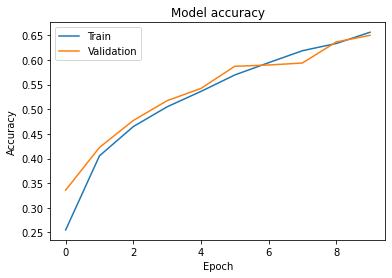

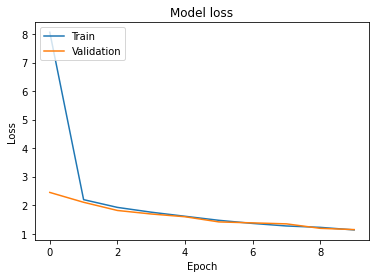

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Calculate test set

In [9]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(pp_test)
print('test loss, test acc:', results)


# Evaluate on test data
43/43 [==============================] - 8s 194ms/step - loss: 1.1451 - sparse_categorical_accuracy: 0.6576
test loss, test acc: [1.145106315612793, 0.6576427221298218]


### (20 pts.) The Convolutional Neural Network implementation

#### It is a 4 layer Convolutional Neural Network. First two layers are Convolutional and last two layers are Fully Connected. The depths are [64,128,64] and the last softmax layer has 38 output. Train for 10 epochs, with 0.001 learning rate and categorical cross entropy.

In [10]:
model_cnn = tf.keras.models.Sequential([
  ### Conv2D layer
  tf.keras.layers.Conv2D(filters=64 , kernel_size=(3,3) ,  strides=2 , activation='relu' , input_shape=(256,256,3)),
  ### MaxPooling2D layer
  tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides=1 , padding='same'),
  ### Conv2D layer
  tf.keras.layers.Conv2D(filters=128 , kernel_size=(3,3) ,  strides=2 , activation='relu'),
  ### MaxPooling2D layer
  tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides=1 , padding='same'),
  ### Flatten
  tf.keras.layers.Flatten(),
  ### Dense
  tf.keras.layers.Dense(64, activation='relu'),
  ### Dense softmax
  tf.keras.layers.Dense(38, activation='softmax')
])

model_cnn.compile(
    ### loss function sparse_categorical_crossentropy
    loss='sparse_categorical_crossentropy',
    ### Adam optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    ### metrics
    metrics=['sparse_categorical_accuracy']
)

history_cnn = model_cnn.fit(
    pp_train,
    epochs=10,
    validation_data=pp_val,
)

Epoch 1/10
340/340 [==============================] - 131s 387ms/step - loss: 1.6243 - sparse_categorical_accuracy: 0.5862 - val_loss: 0.8562 - val_sparse_categorical_accuracy: 0.7527
Epoch 2/10
340/340 [==============================] - 132s 389ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.8267 - val_loss: 0.5653 - val_sparse_categorical_accuracy: 0.8284
Epoch 3/10
340/340 [==============================] - 133s 390ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8937 - val_loss: 0.5748 - val_sparse_categorical_accuracy: 0.8389
Epoch 4/10
340/340 [==============================] - 132s 388ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.5698 - val_sparse_categorical_accuracy: 0.8464
Epoch 5/10
340/340 [==============================] - 132s 387ms/step - loss: 0.1600 - sparse_categorical_accuracy: 0.9463 - val_loss: 0.5810 - val_sparse_categorical_accuracy: 0.8532
Epoch 6/10
340/340 [==============================] - 132s 388ms/step - loss: 0.

#### Plot training & validation accuracy values

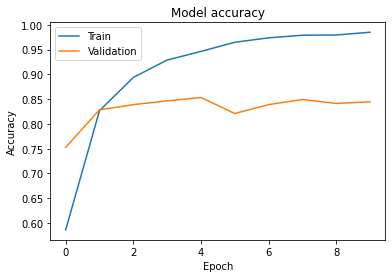

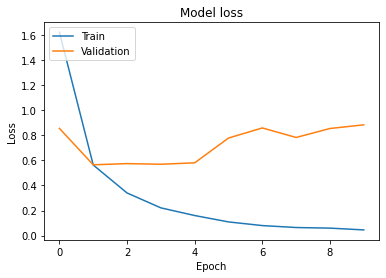

In [12]:
# Plot training & validation accuracy values
plt.plot(history_cnn.history['sparse_categorical_accuracy'])
plt.plot(history_cnn.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Calculate test set

In [13]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model_cnn.evaluate(pp_test)
print('test loss, test acc:', results)


# Evaluate on test data
43/43 [==============================] - 12s 278ms/step - loss: 0.8183 - sparse_categorical_accuracy: 0.8459
test loss, test acc: [0.8183156847953796, 0.8458563685417175]
